In [25]:
!pip install --upgrade transformers torch transformers[torch] tokenizers huggingface_hub pytorch-crf
!pip install protobuf==3.20.3

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable


In [1]:
import torch
torch.cuda.empty_cache()

assert torch.cuda.is_available()

In [2]:
device_name = torch.cuda.get_device_name()
n_gpu = torch.cuda.device_count()
print(f"Found device: {device_name}, n_gpu: {n_gpu}")
device = torch.device("cuda")

Found device: NVIDIA A100-SXM4-80GB MIG 3g.40gb, n_gpu: 1


In [3]:
import random
import numpy as np

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed_everything()

In [4]:
import pandas as pd

def read_conll(file_path):
    sentences = []
    labels = []
    current_sentence = []
    current_labels = []

    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if line:
                columns = line.split()
                word, label = columns[0], columns[-1]
                current_sentence.append(word)
                current_labels.append(label)
                
                # Check if the current word is a sentence boundary
                if word == '.' and label == 'O':
                    sentences.append(' '.join(current_sentence))
                    labels.append(current_labels)
                    current_sentence = []
                    current_labels = []

    # Create a DataFrame from the accumulated sentences and labels
    df = pd.DataFrame({
        'sentences': sentences,
        'labels': labels
    })
    return df


In [5]:
import torch
max_length=128

def tokenize_and_format(sentences, tokenizer, max_length=max_length):
    """
    Tokenizes sentences and returns formatted input IDs and attention masks.
    
    Parameters:
    sentences: List of sentence strings to be tokenized.
    tokenizer: Tokenizer instance used for tokenizing the sentences.
    """
    input_ids = []
    attention_masks = []

    # Encode each sentence
    for sentence in sentences:
        encoded_dict = tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
            max_length=max_length,  # Adjust based on your model's maximum input length
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        # Store the input ID and the attention mask of this sentence
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert lists of tensors to single tensors
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

In [6]:
from transformers import AutoTokenizer

model_name = 'worldbank/econberta'
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=True)

/home/cbekal/.local/lib/python3.9/site-packages/transformers/convert_slow_tokenizer.py:550: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [7]:
label_dict = {
    'O': 0,
    'B-intervention': 1,
    'I-intervention': 2,
    'B-outcome': 3,
    'I-outcome': 4,
    'B-population': 5,
    'I-population': 6,
    'B-effect_size': 7,
    'I-effect_size': 8,
    'B-coreference': 9,
    'I-coreference': 10
}

In [8]:
reverse_label_dict = {v: k for k, v in label_dict.items()}

In [9]:
import numpy as np
import torch

def get_dataset(df, tokenizer, label_dict, max_length=max_length):
    """
    Processes a DataFrame to return a dataset suitable for training/testing an NER model.
    
    Parameters:
    df: DataFrame containing 'Tokens' and 'Labels' columns.
    tokenizer: Tokenizer to use for encoding the sentences.
    label_dict: Dictionary mapping label names to indices.
    max_length: Maximum length of the tokenized input.
    """
    sentences = df.sentences.values
    
    # Tokenize sentences
    input_ids, attention_masks = tokenize_and_format(sentences, tokenizer, max_length)

    # Prepare labels
    label_list = []
    for labels in df.labels.values:
        # Initialize a list to hold the encoded labels for each sentence
        encoded_labels = [label_dict[label] for label in labels]
        
        # Truncate or pad the labels to match the max_length
        encoded_labels = encoded_labels[:max_length]  # Truncate if needed
        encoded_labels += [label_dict['O']] * (max_length - len(encoded_labels))  # Pad with 'O' if needed
        
        label_list.append(encoded_labels)

    # Convert label_list to a tensor
    labels = torch.tensor(label_list, dtype=torch.long)

    # Create the dataset
    dataset = [(input_ids[i], attention_masks[i], labels[i]) for i in range(len(df))]

    return dataset, sentences

In [10]:
seed_everything()

train_df = read_conll('data/econ_ie/train.conll')
val_df = read_conll('data/econ_ie/dev.conll')
test_df = read_conll('data/econ_ie/test.conll')

train_set, train_sentences = get_dataset(train_df, tokenizer, label_dict)
val_set, val_sentences = get_dataset(val_df, tokenizer, label_dict)
test_set, test_sentences = get_dataset(test_df, tokenizer, label_dict)

In [133]:
print(len(train_sentences))

4798


In [128]:
seed_everything()
train_typo_df = train_df.sample(n=500)

In [129]:
import pandas as pd
import numpy as np
import random

def introduce_typos(text, typo_rate=0.1):
    """
    Introduce 1 or 2 simple typos into the given text.
    Typos can be a character insertion or substitution.
    """
    letters = 'abcdefghijklmnopqrstuvwxyz'
    num_typos = random.randint(1, 2)  # Choose to introduce either 1 or 2 typos
    
    for _ in range(num_typos):
        typo_type = random.choice(['insert', 'substitute'])
        pos = random.randint(0, len(text) - 1)
        
        if typo_type == 'insert':
            char_to_add = random.choice(letters)
            text = text[:pos] + char_to_add + text[pos:]
        elif typo_type == 'substitute' and len(text) > 0:
            text = text[:pos] + random.choice(letters) + text[pos + 1:]
    
    return ''.join(text)

# Apply the typo function to the 'sentence' column
train_typo_df['perturbated_sentence'] = train_typo_df['sentences'].apply(introduce_typos)

# Create a new DataFrame with perturbated sentences and original labels
new_train_typos_df = train_typo_df[['perturbated_sentence', 'labels']].copy()

# Display the new DataFrame
new_train_typos_df

new_train_typos_df.rename(columns={'perturbated_sentence': 'sentences'}, inplace=True)

In [130]:
new_train_typos_df

,sentences,labels
561,By integrating the process of abolishing the a...,"[O, O, O, O, O, B-intervention, I-intervention..."
893,Estimated mean child dietary diversxity was si...,"[O, B-outcome, I-outcome, I-outcome, I-outcome..."
1684,Interventions in rural development projects va...,"[B-coreference, O, O, O, O, O, O, O, O, O, O, ..."
705,Conclusions These resulgts suggest that permet...,"[O, O, O, O, O, B-intervention, I-intervention..."
1873,Methods : This randomized clinical trial enrol...,"[O, O, O, O, O, O, O, O, B-population, I-popul..."
...,...,...
2822,The data were analysed using sescriptive stati...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2473,Results show that the increase in parking pric...,"[O, O, O, O, B-intervention, I-intervention, I..."
4534,We observed a 41 % reduction in diarrheal morb...,"[O, O, O, B-effect_size, I-effect_size, O, O, ..."
3473,These findings demonstrate that a simple and i...,"[O, O, O, O, O, O, O, O, B-coreference, O, O, ..."


In [148]:
train_set, train_sentences = get_dataset(new_train_df, tokenizer, label_dict)

In [150]:
seed_everything()
val_typo_df = val_df.sample(n=100)

In [151]:
import pandas as pd
import numpy as np
import random

def introduce_typos(text, typo_rate=0.1):
    """
    Introduce 1 or 2 simple typos into the given text.
    Typos can be a character insertion or substitution.
    """
    letters = 'abcdefghijklmnopqrstuvwxyz'
    num_typos = random.randint(1, 2)  # Choose to introduce either 1 or 2 typos
    
    for _ in range(num_typos):
        typo_type = random.choice(['insert', 'substitute'])
        pos = random.randint(0, len(text) - 1)
        
        if typo_type == 'insert':
            char_to_add = random.choice(letters)
            text = text[:pos] + char_to_add + text[pos:]
        elif typo_type == 'substitute' and len(text) > 0:
            text = text[:pos] + random.choice(letters) + text[pos + 1:]
    
    return ''.join(text)

# Apply the typo function to the 'sentence' column
val_typo_df['perturbated_sentence'] = val_typo_df['sentences'].apply(introduce_typos)

# Create a new DataFrame with perturbated sentences and original labels
new_val_typos_df = val_typo_df[['perturbated_sentence', 'labels']].copy()

# Display the new DataFrame
new_val_typos_df

new_val_typos_df.rename(columns={'perturbated_sentence': 'sentences'}, inplace=True)

In [152]:
new_val_df = pd.concat([val_df, new_val_typos_df], axis=0)

In [158]:
val_set, val_sentences = get_dataset(new_val_df, tokenizer, label_dict)

In [135]:
seed_everything()
df = test_df.sample(n=100)

In [120]:
df_set, df_sentences = get_dataset(df, tokenizer, label_dict)

In [137]:
import pandas as pd
import numpy as np
import random

def introduce_typos(text, typo_rate=0.1):
    """
    Introduce 1 or 2 simple typos into the given text.
    Typos can be a character insertion or substitution.
    """
    letters = 'abcdefghijklmnopqrstuvwxyz'
    num_typos = random.randint(1, 2)  # Choose to introduce either 1 or 2 typos
    
    for _ in range(num_typos):
        typo_type = random.choice(['insert', 'substitute'])
        pos = random.randint(0, len(text) - 1)
        
        if typo_type == 'insert':
            char_to_add = random.choice(letters)
            text = text[:pos] + char_to_add + text[pos:]
        elif typo_type == 'substitute' and len(text) > 0:
            text = text[:pos] + random.choice(letters) + text[pos + 1:]
    
    return ''.join(text)

# Apply the typo function to the 'sentence' column
df['perturbated_sentence'] = df['sentences'].apply(introduce_typos)

# Create a new DataFrame with perturbated sentences and original labels
new_df = df[['perturbated_sentence', 'labels']].copy()

# Display the new DataFrame
new_df

,perturbated_sentence,labels
567,"In particular , relatively few studies have be...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1326,These findings suggest that risk-targeted paym...,"[O, O, O, O, B-intervention, I-intervention, O..."
1061,The basic idea is that while both constrained ...,"[O, O, O, O, O, O, O, B-population, I-populati..."
115,All interventions significantly improved the x...,"[O, O, O, O, O, B-outcome, I-outcome, I-outcom..."
453,"Here , we evaluated the short - , medium - and...","[O, O, O, O, O, O, O, O, O, O, O, O, O, B-core..."
...,...,...
300,Data were collzcted using a well-structured qu...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
677,Methods : The procedure wts designed as a sing...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
707,"Moreover , little is known about how the desig...","[O, O, O, O, O, O, O, O, O, O, B-intervention,..."
30,A cost-effectiveness analysis of the results v...,"[O, O, O, O, O, O, O, O, B-intervention, I-int..."


In [138]:
new_df.rename(columns={'perturbated_sentence': 'sentences'}, inplace=True)

In [172]:
test_typos_df = pd.concat([test_df, new_df], axis=0)

In [173]:
test_typos_set, test_typos_sentences = get_dataset(test_typos_df, tokenizer, label_dict)

In [139]:
typos_set, typos_sentences = get_dataset(new_df, tokenizer, label_dict)

In [140]:
typos_set[0]

(tensor([    1,   267,  1070,   366,  2936,   477,  1703,   286,   331,   619,
           277,   262, 13269,  4500,  1204,  3727,   308,  1382,   372,  1431,
           366,  2128,  1479,  1519,   292,  4856,   272,   262,  1382,   265,
           614, 13624, 25084,   295,  4388,  1579,   262,  7226,   289, 77580,
         36518,   272,  2836,   349,   366,  4395,  1601,   264, 77580, 36518,
          1137,   333, 14507, 14471,   323,     2,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

In [11]:
train_set[0]

(tensor([    1,   287,   376,  1263,  1770,   268, 11254,   264,  5685, 17736,
           267,  4770,  3791,   263,  3922,   323,     2,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

In [159]:
# Set the hyperparameters according to Table 8
dropout = 0.2
learning_rates = [5e-5, 6e-5, 7e-5]  # Perform hyperparameter search
batch_size = 12
gradient_accumulation_steps = 4
weight_decay = 0
max_epochs = 10
lr_decay = "slanted_triangular"
fraction_of_steps = 0.06
adam_epsilon = 1e-8
adam_beta1 = 0.9
adam_beta2 = 0.999

seed_everything()

In [160]:
def preprocess_entities(labels, tokens):
    """
    Extract entities from token-label pairs.
    
    Args:
    labels (list of int): List of label indices corresponding to each token.
    tokens (list of str): List of tokens corresponding to each label index.
    
    Returns:
    list of tuples: Each tuple represents an entity with (entity_type, start_index, end_index, entity_text).
    """
    entities = []
    current_entity = None

    for i, (token, label) in enumerate(zip(tokens, labels)):
        if label.startswith("B-"):
            if current_entity:
                entities.append(current_entity)
            entity_type = label.split("-")[1]
            current_entity = (entity_type, i, i, token)
        elif label.startswith("I-") and current_entity and label.split("-")[1] == current_entity[0]:
            current_entity = (current_entity[0], current_entity[1], i, current_entity[3] + " " + token)
        else:
            if current_entity:
                entities.append(current_entity)
                current_entity = None

    if current_entity:
        entities.append(current_entity)

    return entities

In [161]:
def compute_entity_level_metrics(true_entities, pred_entities):
    metrics = {"EM": 0, "EB": 0, "PM": 0, "PB": 0, "ML": 0, "FA": 0}
    true_matched = set()
    pred_matched = set()

    # Check for exact and partial matches
    for i, true_entity in enumerate(true_entities):
        for j, pred_entity in enumerate(pred_entities):
            if j in pred_matched:
                continue
            if true_entity == pred_entity:
                metrics["EM"] += 1
                true_matched.add(i)
                pred_matched.add(j)
                break
            elif true_entity[0] == pred_entity[0] and is_overlapping((true_entity[1], true_entity[2]), (pred_entity[1], pred_entity[2])):
                if true_entity[1] == pred_entity[1] and true_entity[2] == pred_entity[2]:
                    metrics["EB"] += 1
                else:
                    metrics["PM"] += 1
                true_matched.add(i)
                pred_matched.add(j)
                break
            elif is_overlapping((true_entity[1], true_entity[2]), (pred_entity[1], pred_entity[2])):
                metrics["PB"] += 1
                true_matched.add(i)
                pred_matched.add(j)
                break

    # Check for missed labels (entities in true but not in pred)
    for i, true_entity in enumerate(true_entities):
        if i not in true_matched:
            metrics["ML"] += 1

    # Check for false alarms (entities in pred but not in true)
    for j, pred_entity in enumerate(pred_entities):
        if j not in pred_matched:
            metrics["FA"] += 1

    return metrics

In [162]:
def is_overlapping(span1, span2):
    """
    Check if two spans overlap.
    Args:
    span1, span2 (tuple): (start_index, end_index) of the span.

    Returns:
    bool: True if spans overlap, False otherwise.
    """
    assert len(span1) == 2 and len(span2) == 2, "Each span must be a tuple of two elements (start_index, end_index)"
    start1, end1 = span1
    start2, end2 = span2
    return max(start1, start2) <= min(end1, end2)

In [163]:
print(label_dict)

{'O': 0, 'B-intervention': 1, 'I-intervention': 2, 'B-outcome': 3, 'I-outcome': 4, 'B-population': 5, 'I-population': 6, 'B-effect_size': 7, 'I-effect_size': 8, 'B-coreference': 9, 'I-coreference': 10}


In [164]:
from collections import defaultdict

def analyze_generalization(model, data, tokenizer, train_words):
    grouped_entities = defaultdict(lambda: ([], []))  # {group_name: (true_entities, pred_entities)}        
    groups=[]
    mtrcs=[]

    for i, (input_ids, attention_mask, label_tensor) in enumerate(data):
        input_ids = input_ids.unsqueeze(0).to(device)
        attention_mask = attention_mask.unsqueeze(0).to(device)
        
        # Call model without labels to get the decoded labels
        with torch.no_grad():
            decoded_labels = model(input_ids, attention_mask=attention_mask)["decoded"][0]
            # No need to use argmax since CRF.decode returns the most likely tag sequence
        
        # Convert the decoded labels to label names using label_dict
        pred_labels = [reverse_label_dict.get(label) for label in decoded_labels]

        # Convert input_ids to tokens
        tokens = tokenizer.convert_ids_to_tokens(input_ids[0].tolist(), skip_special_tokens=True)

        # Assuming true_labels are provided in a similar structure
        true_labels = [reverse_label_dict.get(l.item()) for l in label_tensor]
        
        # Preprocess entities for true and predicted labels
        true_entities = preprocess_entities(true_labels, tokens)
        pred_entities = preprocess_entities(pred_labels, tokens)
        
        for true_entity, pred_entity in zip(true_entities, pred_entities):
            length = true_entity[2] - true_entity[1]

            seen = any(word in train_words for word in true_entity[3].split())  # Check if any word in entity text was seen in training

            group_name = f"Length {length} - {'Seen' if seen else 'Unseen'}"
            grouped_entities[group_name][0].append(true_entity)
            grouped_entities[group_name][1].append(pred_entity)
    
    for group_name, group_data in grouped_entities.items():
        group_true_entities, group_pred_entities = group_data
        metrics = compute_entity_level_metrics(group_true_entities, group_pred_entities)
        print(f"Group: {group_name}, Metrics: {metrics}")
        groups.append(group_name)
        mtrcs.append(metrics)
        
    return groups, mtrcs

In [165]:
from sklearn.metrics import classification_report
import torch
import numpy as np

def get_validation_performance(val_set, model, device, label_dict, batch_size):
    # Put the model in evaluation mode
    model.eval()

    # Tracking variables
    total_eval_loss = 0
    all_pred_labels = []
    all_true_labels = []

    num_batches = int(len(val_set) / batch_size) + (1 if len(val_set) % batch_size != 0 else 0)

    for i in range(num_batches):
        end_index = min(batch_size * (i + 1), len(val_set))
        batch = val_set[i * batch_size:end_index]

        if len(batch) == 0:
            continue

        input_id_tensors = torch.stack([data[0] for data in batch])
        input_mask_tensors = torch.stack([data[1] for data in batch])
        label_tensors = torch.stack([data[2] for data in batch])

        # Move tensors to the GPU
        b_input_ids = input_id_tensors.to(device)
        b_input_mask = input_mask_tensors.to(device)
        b_labels = label_tensors.to(device)
        b_labels = b_labels.long()

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
            loss = outputs["loss"]
            logits = outputs["logits"]

            # Accumulate the validation loss.
            total_eval_loss += loss.item()

            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            # Get the predicted labels
            pred_labels = np.argmax(logits, axis=2).flatten()
            true_labels = label_ids.flatten()

            # Convert labels to their original names
            pred_labels = [reverse_label_dict.get(label) for label in pred_labels]
            true_labels = [reverse_label_dict.get(label) for label in true_labels]

            # Filter out special tokens ('O' label is used for non-entity and special tokens)
            filtered_pred_labels = [pred for pred, true in zip(pred_labels, true_labels) if true != 'O']
            filtered_true_labels = [true for true in true_labels if true != 'O']
            
            # After filtering out special tokens
            if not filtered_pred_labels or not filtered_true_labels:
                print("Warning: No non-'O' labels found in this batch.")
            else:
                all_pred_labels.extend(filtered_pred_labels)
                all_true_labels.extend(filtered_true_labels)
            
    # After processing all batches, check if we have any labels to report on
    if not all_true_labels or not all_pred_labels:
        print("Error: No non-'O' labels found in the entire validation set.")
        default_labels = [list(label_dict.values())[0]]  # Use the first label as a placeholder
        report = classification_report(default_labels, default_labels, digits=4, zero_division=0)
    else:
        # Calculate precision, recall, and F1 score
        report = classification_report(all_true_labels, all_pred_labels, digits=4, zero_division=0)

    return report


In [166]:
from torchcrf import CRF
from transformers import AutoModel

class CRFTagger(torch.nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = torch.nn.Dropout(dropout)
        self.classifier = torch.nn.Linear(self.bert.config.hidden_size, num_labels)
        self.crf = CRF(num_labels, batch_first=True)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        sequence_output = outputs[0]
        sequence_output = self.dropout(sequence_output)
        logits = self.classifier(sequence_output)

        # Mask should be of type 'bool' in newer PyTorch versions
        mask = attention_mask.type(torch.bool) if hasattr(torch, 'bool') else attention_mask.byte()
        
        if labels is not None:
            loss = -self.crf(logits, labels, mask=mask, reduction='mean')
            return {'loss': loss, 'logits': logits, 'decoded': self.crf.decode(logits, mask=mask)}
        else:
            decoded_labels = self.crf.decode(logits, mask=mask)
            return {'decoded': decoded_labels, 'logits': logits}

In [167]:
seed_everything()

# Load the pre-trained model
model = CRFTagger(model_name, len(label_dict))
model.dropout = torch.nn.Dropout(dropout)
model.to(device)

CRFTagger(
  (bert): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
              (dropou

In [168]:
from transformers import get_linear_schedule_with_warmup, AdamW
import time

# Calculate the total number of training steps
total_steps = (len(train_set) // (batch_size * gradient_accumulation_steps)) * max_epochs

lr = learning_rates[2]
# for lr in learning_rates:
print(f"Current learning rate: {lr}")

# Create the optimizer with the specified hyperparameters
optimizer = AdamW(model.parameters(), lr=lr, eps=adam_epsilon, betas=(adam_beta1, adam_beta2), weight_decay=weight_decay, no_deprecation_warning=True)

# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(total_steps * fraction_of_steps), num_training_steps=total_steps)

# Training loop
for epoch_i in range(max_epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, max_epochs))
    print('Training...')

    total_train_loss = 0
    model.train()

    num_batches = int(len(train_set) / batch_size) + (1 if len(train_set) % batch_size != 0 else 0)

    for i in range(num_batches):
        end_index = min(batch_size * (i + 1), len(train_set))
        batch = train_set[i * batch_size:end_index]

        if len(batch) == 0:
            continue

        input_id_tensors = torch.stack([data[0] for data in batch])
        input_mask_tensors = torch.stack([data[1] for data in batch])
        label_tensors = torch.stack([data[2] for data in batch])

        b_input_ids = input_id_tensors.to(device)
        b_input_mask = input_mask_tensors.to(device)
        b_labels = label_tensors.long().to(device)

        model.zero_grad()
        outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs["loss"]
        total_train_loss += loss.item()

        # Accumulate gradients
        loss = loss / gradient_accumulation_steps
        loss.backward()

        # Perform optimizer step after accumulating gradients for gradient_accumulation_steps
        if (i + 1) % gradient_accumulation_steps == 0 or i == num_batches - 1:  # Ensure step is taken on the last batch
            optimizer.step()
            scheduler.step()
            model.zero_grad()

    print(f"Total loss: {total_train_loss}")
    report = get_validation_performance(val_set, model, device, label_dict, batch_size)
    print(report)
    analyze_generalization(model, val_set, tokenizer, train_sentences)

print("")
print(f"Training complete at learning rate: {lr}!")

timestamp = time.strftime("%Y%m%d-%H%M%S")
print(f"EconBERTa Model saved at: {timestamp}")
torch.save(model.state_dict(), f'econberta_typos_lr-{lr}_{timestamp}.pth')

print("")
print(f"Training complete!")

Current learning rate: 7e-05

======== Epoch 1 / 10 ========
Training...
Total loss: 20006.89262008667
                precision    recall  f1-score   support

 B-coreference     0.0000    0.0000    0.0000       285
 B-effect_size     0.0000    0.0000    0.0000       158
B-intervention     0.0000    0.0000    0.0000       796
     B-outcome     0.0000    0.0000    0.0000      1169
  B-population     0.0000    0.0000    0.0000       689
 I-coreference     0.0000    0.0000    0.0000         8
 I-effect_size     0.0000    0.0000    0.0000       305
I-intervention     0.7060    0.3227    0.4429      1816
     I-outcome     0.5833    0.0246    0.0473      1988
  I-population     0.0000    0.0000    0.0000       692
             O     0.0000    0.0000    0.0000         0

      accuracy                         0.0803      7906
     macro avg     0.1172    0.0316    0.0446      7906
  weighted avg     0.3089    0.0803    0.1136      7906

Group: Length 2 - Unseen, Metrics: {'EM': 0, 'EB': 0, 

Group: Length 1 - Unseen, Metrics: {'EM': 70, 'EB': 26, 'PM': 146, 'PB': 265, 'ML': 14, 'FA': 14}
Group: Length 0 - Unseen, Metrics: {'EM': 67, 'EB': 108, 'PM': 40, 'PB': 402, 'ML': 33, 'FA': 33}
Group: Length 6 - Unseen, Metrics: {'EM': 2, 'EB': 0, 'PM': 13, 'PB': 14, 'ML': 3, 'FA': 3}
Group: Length 2 - Unseen, Metrics: {'EM': 20, 'EB': 5, 'PM': 77, 'PB': 78, 'ML': 7, 'FA': 7}
Group: Length 3 - Unseen, Metrics: {'EM': 13, 'EB': 1, 'PM': 39, 'PB': 54, 'ML': 6, 'FA': 6}
Group: Length 7 - Unseen, Metrics: {'EM': 0, 'EB': 0, 'PM': 8, 'PB': 13, 'ML': 3, 'FA': 3}
Group: Length 5 - Unseen, Metrics: {'EM': 3, 'EB': 1, 'PM': 21, 'PB': 19, 'ML': 3, 'FA': 3}
Group: Length 4 - Unseen, Metrics: {'EM': 8, 'EB': 1, 'PM': 32, 'PB': 30, 'ML': 3, 'FA': 3}
Group: Length 9 - Unseen, Metrics: {'EM': 1, 'EB': 0, 'PM': 1, 'PB': 5, 'ML': 2, 'FA': 2}
Group: Length 11 - Unseen, Metrics: {'EM': 0, 'EB': 0, 'PM': 7, 'PB': 0, 'ML': 1, 'FA': 1}
Group: Length 8 - Unseen, Metrics: {'EM': 2, 'EB': 0, 'PM': 4, 'PB': 4

Total loss: 6838.122786283493
                precision    recall  f1-score   support

 B-coreference     0.8679    0.4842    0.6216       285
 B-effect_size     0.6111    0.2785    0.3826       158
B-intervention     0.7442    0.6068    0.6685       796
     B-outcome     0.7454    0.5885    0.6577      1169
  B-population     0.7660    0.5747    0.6567       689
 I-coreference     0.0000    0.0000    0.0000         8
 I-effect_size     0.7872    0.6066    0.6852       305
I-intervention     0.8894    0.6641    0.7604      1816
     I-outcome     0.8810    0.6258    0.7318      1988
  I-population     0.8711    0.5665    0.6865       692
             O     0.0000    0.0000    0.0000         0

      accuracy                         0.6041      7906
     macro avg     0.6512    0.4541    0.5319      7906
  weighted avg     0.8278    0.6041    0.6970      7906

Group: Length 1 - Unseen, Metrics: {'EM': 41, 'EB': 47, 'PM': 234, 'PB': 441, 'ML': 23, 'FA': 23}
Group: Length 2 - Unseen, Met

In [175]:
# Load state_dict of the model
model.load_state_dict(torch.load(f'econmodel_lr-7e-05_20240429-114015.pth'))

<All keys matched successfully>

In [169]:
model.load_state_dict(torch.load(f'econberta_typos_lr-7e-05_20240503-190205.pth'))

<All keys matched successfully>

In [170]:
print(get_validation_performance(test_set, model, device, label_dict, batch_size))

                precision    recall  f1-score   support

 B-coreference     0.8980    0.4800    0.6256       550
 B-effect_size     0.5833    0.2188    0.3182       320
B-intervention     0.7150    0.5414    0.6162      1330
     B-outcome     0.6911    0.5105    0.5872      1718
  B-population     0.7334    0.5432    0.6242      1018
 I-coreference     0.0000    0.0000    0.0000        22
 I-effect_size     0.7917    0.3548    0.4900       482
I-intervention     0.8651    0.6309    0.7296      2663
     I-outcome     0.8764    0.5787    0.6971      3235
  I-population     0.8525    0.6218    0.7191      1227
             O     0.0000    0.0000    0.0000         0

      accuracy                         0.5547     12565
     macro avg     0.6370    0.4073    0.4916     12565
  weighted avg     0.8064    0.5547    0.6547     12565



In [171]:
print(get_validation_performance(typos_set, model, device, label_dict, batch_size))

                precision    recall  f1-score   support

 B-coreference     0.8000    0.2286    0.3556        35
 B-effect_size     0.2000    0.0323    0.0556        31
B-intervention     0.5833    0.4023    0.4762        87
     B-outcome     0.6279    0.3140    0.4186        86
  B-population     0.5000    0.4390    0.4675        41
 I-coreference     0.0000    0.0000    0.0000         3
 I-effect_size     0.6923    0.1875    0.2951        48
I-intervention     0.9216    0.5839    0.7148       161
     I-outcome     0.8649    0.4571    0.5981       140
  I-population     0.8571    0.4918    0.6250        61
             O     0.0000    0.0000    0.0000         0

      accuracy                         0.4127       693
     macro avg     0.5497    0.2851    0.3642       693
  weighted avg     0.7423    0.4127    0.5222       693



In [174]:
print(get_validation_performance(test_typos_set, model, device, label_dict, batch_size))

                precision    recall  f1-score   support

 B-coreference     0.8947    0.4650    0.6119       585
 B-effect_size     0.5680    0.2023    0.2983       351
B-intervention     0.7076    0.5328    0.6079      1417
     B-outcome     0.6890    0.5011    0.5802      1804
  B-population     0.7228    0.5392    0.6176      1059
 I-coreference     0.0000    0.0000    0.0000        25
 I-effect_size     0.7860    0.3396    0.4743       530
I-intervention     0.8679    0.6282    0.7288      2824
     I-outcome     0.8760    0.5736    0.6933      3375
  I-population     0.8527    0.6157    0.7151      1288
             O     0.0000    0.0000    0.0000         0

      accuracy                         0.5473     13258
     macro avg     0.6332    0.3998    0.4843     13258
  weighted avg     0.8038    0.5473    0.6483     13258



In [176]:
print(get_validation_performance(test_typos_set, model, device, label_dict, batch_size))

                precision    recall  f1-score   support

 B-coreference     0.8831    0.4906    0.6308       585
 B-effect_size     0.6667    0.3533    0.4618       351
B-intervention     0.7271    0.5716    0.6401      1417
     B-outcome     0.6884    0.5671    0.6219      1804
  B-population     0.7445    0.6025    0.6660      1059
 I-coreference     0.0000    0.0000    0.0000        25
 I-effect_size     0.8175    0.4057    0.5422       530
I-intervention     0.8669    0.6183    0.7218      2824
     I-outcome     0.8829    0.5899    0.7073      3375
  I-population     0.8776    0.5955    0.7095      1288
             O     0.0000    0.0000    0.0000         0

      accuracy                         0.5733     13258
     macro avg     0.6504    0.4359    0.5183     13258
  weighted avg     0.8148    0.5733    0.6707     13258



In [121]:
print(get_validation_performance(df_set, model, device, label_dict, batch_size))

                precision    recall  f1-score   support

 B-coreference     1.0000    0.6667    0.8000        24
 B-effect_size     0.6250    0.3125    0.4167        16
B-intervention     0.6364    0.5632    0.5976        87
     B-outcome     0.6264    0.4750    0.5403       120
  B-population     0.7358    0.5652    0.6393        69
 I-effect_size     0.7273    0.5333    0.6154        30
I-intervention     0.8333    0.6928    0.7566       166
     I-outcome     0.7951    0.5052    0.6178       192
  I-population     0.8333    0.4386    0.5747        57
             O     0.0000    0.0000    0.0000         0

      accuracy                         0.5506       761
     macro avg     0.6813    0.4753    0.5558       761
  weighted avg     0.7564    0.5506    0.6337       761



In [25]:
bert_lengths, bert_metrics = analyze_generalization(model, test_set, tokenizer, train_sentences)

Group: Length 3 - Unseen, Metrics: {'EM': 1, 'EB': 4, 'PM': 100, 'PB': 171, 'ML': 12, 'FA': 12}
Group: Length 4 - Unseen, Metrics: {'EM': 7, 'EB': 0, 'PM': 58, 'PB': 95, 'ML': 10, 'FA': 10}
Group: Length 0 - Unseen, Metrics: {'EM': 107, 'EB': 253, 'PM': 82, 'PB': 1059, 'ML': 72, 'FA': 72}
Group: Length 2 - Unseen, Metrics: {'EM': 8, 'EB': 11, 'PM': 138, 'PB': 287, 'ML': 25, 'FA': 25}
Group: Length 1 - Unseen, Metrics: {'EM': 41, 'EB': 40, 'PM': 323, 'PB': 609, 'ML': 33, 'FA': 33}
Group: Length 5 - Unseen, Metrics: {'EM': 3, 'EB': 2, 'PM': 55, 'PB': 60, 'ML': 6, 'FA': 6}
Group: Length 9 - Unseen, Metrics: {'EM': 1, 'EB': 0, 'PM': 8, 'PB': 10, 'ML': 6, 'FA': 6}
Group: Length 7 - Unseen, Metrics: {'EM': 1, 'EB': 0, 'PM': 19, 'PB': 24, 'ML': 3, 'FA': 3}
Group: Length 10 - Unseen, Metrics: {'EM': 0, 'EB': 0, 'PM': 6, 'PB': 6, 'ML': 3, 'FA': 3}
Group: Length 8 - Unseen, Metrics: {'EM': 1, 'EB': 0, 'PM': 22, 'PB': 20, 'ML': 5, 'FA': 5}
Group: Length 11 - Unseen, Metrics: {'EM': 0, 'EB': 0, 'P

In [26]:
lengths

['Length 3 - Unseen',
 'Length 4 - Unseen',
 'Length 0 - Unseen',
 'Length 2 - Unseen',
 'Length 1 - Unseen',
 'Length 5 - Unseen',
 'Length 9 - Unseen',
 'Length 7 - Unseen',
 'Length 10 - Unseen',
 'Length 8 - Unseen',
 'Length 11 - Unseen',
 'Length 6 - Unseen',
 'Length 12 - Unseen',
 'Length 13 - Unseen',
 'Length 16 - Unseen',
 'Length 17 - Unseen',
 'Length 18 - Unseen',
 'Length 32 - Unseen',
 'Length 14 - Unseen',
 'Length 19 - Unseen']

In [27]:
metrics

[{'EM': 1, 'EB': 4, 'PM': 100, 'PB': 171, 'ML': 12, 'FA': 12},
 {'EM': 7, 'EB': 0, 'PM': 58, 'PB': 95, 'ML': 10, 'FA': 10},
 {'EM': 107, 'EB': 253, 'PM': 82, 'PB': 1059, 'ML': 72, 'FA': 72},
 {'EM': 8, 'EB': 11, 'PM': 138, 'PB': 287, 'ML': 25, 'FA': 25},
 {'EM': 41, 'EB': 40, 'PM': 323, 'PB': 609, 'ML': 33, 'FA': 33},
 {'EM': 3, 'EB': 2, 'PM': 55, 'PB': 60, 'ML': 6, 'FA': 6},
 {'EM': 1, 'EB': 0, 'PM': 8, 'PB': 10, 'ML': 6, 'FA': 6},
 {'EM': 1, 'EB': 0, 'PM': 19, 'PB': 24, 'ML': 3, 'FA': 3},
 {'EM': 0, 'EB': 0, 'PM': 6, 'PB': 6, 'ML': 3, 'FA': 3},
 {'EM': 1, 'EB': 0, 'PM': 22, 'PB': 20, 'ML': 5, 'FA': 5},
 {'EM': 0, 'EB': 0, 'PM': 3, 'PB': 2, 'ML': 3, 'FA': 3},
 {'EM': 1, 'EB': 0, 'PM': 31, 'PB': 60, 'ML': 7, 'FA': 7},
 {'EM': 0, 'EB': 0, 'PM': 3, 'PB': 0, 'ML': 1, 'FA': 1},
 {'EM': 0, 'EB': 0, 'PM': 2, 'PB': 1, 'ML': 1, 'FA': 1},
 {'EM': 0, 'EB': 0, 'PM': 1, 'PB': 1, 'ML': 1, 'FA': 1},
 {'EM': 0, 'EB': 0, 'PM': 0, 'PB': 1, 'ML': 0, 'FA': 0},
 {'EM': 0, 'EB': 0, 'PM': 3, 'PB': 0, 'ML': 

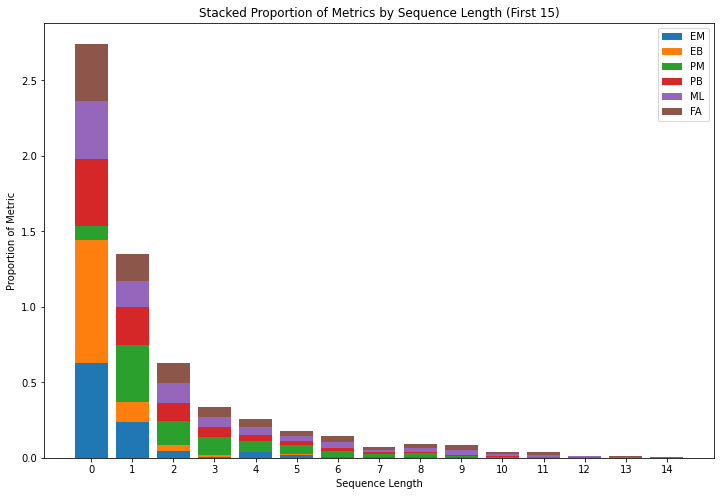

In [32]:
import matplotlib.pyplot as plt

# Extract sequence lengths and sort data by sequence length
sequence_lengths = [int(s.split()[1]) for s in bert_lengths]
sorted_indices = sorted(range(len(sequence_lengths)), key=lambda x: sequence_lengths[x])
sequence_lengths = [sequence_lengths[i] for i in sorted_indices]

# Calculate proportions for each metric
metrics_keys = ['EM', 'EB', 'PM', 'PB', 'ML', 'FA']  # Add other metric keys if needed
proportions = {key: [] for key in metrics_keys}

for key in metrics_keys:
    metric_values = [bert_metrics[i][key] for i in sorted_indices]
    metric_total = sum(metric_values)
    proportions[key] = [value / metric_total for value in metric_values]

# Plot each metric using stacked bar graphs for the first 15 sequence lengths
fig, ax = plt.subplots(figsize=(12, 8))  # Adjust the figure size as needed

# Positions of the bars on the x-axis
indices = range(len(sequence_lengths[:15]))

# Initialize the bottom for the stack
bottom = [0] * 15

for key in metrics_keys:
    ax.bar(indices, proportions[key][:15], bottom=bottom, label=key)
    # Update the bottom position for the next metric
    bottom = [bottom[i] + proportions[key][i] for i in range(15)]

# Labeling
ax.set_xlabel('Entity Length')
ax.set_ylabel('Proportion of Entities')
ax.set_title('Proportion of Entities by Sequence Length (First 15)')
ax.set_xticks(indices)
ax.set_xticklabels(sequence_lengths[:15])
ax.legend()

plt.show()

In [6]:
!pip install checklist

Defaulting to user installation because normal site-packages is not writeable


In [62]:
!pip install --upgrade pydantic

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.3/107.3 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.3/409.3 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 58.8 MB/s eta 0:00:00:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
label-studio 1.4.1.post1 requires pydantic<=1.8.2,>=1.7.3, but you have pydantic 2.7.1 which is incompatible.


In [7]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /home/cbekal/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [22]:
import checklist
from checklist.editor import Editor
from checklist.perturb import Perturb
from checklist.expect import Expect
editor = Editor()

In [23]:
import spacy
from checklist.test_types import MFT, INV, DIR

In [24]:
def extract_entities(df):
    # Assuming df has columns 'sentences' and 'labels'
    entities = []
    current_entity = None

    for index, row in df.iterrows():
        sentence = row['sentences']
        labels = row['labels']
        words = sentence.split()

        for i, (word, label) in enumerate(zip(words, labels)):
            if label.startswith('B-'):
                if current_entity:
                    entities.append(current_entity)
                current_entity = {'type': label[2:], 'start_idx': i, 'end_idx': i, 'text': word}
            elif label.startswith('I-') and current_entity and label[2:] == current_entity['type']:
                current_entity['end_idx'] = i
                current_entity['text'] += ' ' + word
            else:
                if current_entity:
                    entities.append(current_entity)
                    current_entity = None

        if current_entity:
            entities.append(current_entity)
            current_entity = None

    return entities

In [40]:
entities = extract_entities(train_df)
print(len(entities))

15872


In [55]:
entities = entities[:50]

In [56]:
# Define templates with placeholders for populations
population_templates = (
    'The study focused on {population}.',
    'Results were most significant among {population}.',
    'The impact on {population} was noteworthy.',
    'Interventions were targeted towards {population}.',
    'Data was collected from various {population}.',
    'The {population} showed a remarkable response.',
    'Surveys were conducted across different {population}.',
    'The {population} was observed for changes.',
    'A significant change was recorded in the {population}.',
    'The research aimed to benefit the {population}.'
)

# Define custom population entity
populations = [entity['text'] for entity in entities if entity['type']=='population']

# Use the editor to create examples
population_test_cases = editor.template(
    population_templates, 
    meta=True,
    remove_duplicates=True,
    population=populations
)
    
def found_population(x, pred, conf, label=None, meta=None):
    # Check if 'population' is the only entity type present in the prediction
    expected_population = meta['population']
    return all(label == 'O' or label.endswith('population') for label in pred)

found_population_expect_fn = Expect.single(found_population)

# A simple MFT test
found_population_test = MFT(
    **population_test_cases,
    name='Test for correct population recognition',
    capability='NER',
    description='The model should correctly identify and label populations.',
    expect=found_population_expect_fn
)

In [57]:
# Define templates with placeholders for interventions
intervention_templates = (
    "The {intervention} was implemented to address the issue.",
    "Researchers studied the effects of the {intervention}.",
    "The {intervention} had a significant impact on the community.",
    "Funding was provided for the {intervention}.",
    "The success of the {intervention} was evident in the results.",
    "Participants were selected for the {intervention} group.",
    "The {intervention} was a key part of the strategy.",
    "The {intervention} targeted specific outcomes.",
    "Outcomes were measured after the {intervention} took place.",
    "The {intervention} was designed to improve overall outcomes."
)

# Define custom intervention entity
interventions = [entity['text'] for entity in entities if entity['type']=='intervention']

# Use the editor to create examples
intervention_test_cases = editor.template(
    intervention_templates, 
    meta=True,
    remove_duplicates=True,
    intervention=interventions
)

def found_intervention(x, pred, conf, label=None, meta=None):
    # Check if 'intervention' is the only entity type present in the prediction
    expected_intervention = meta['intervention']
    return all(label == 'O' or label.endswith('intervention') for label in pred)

found_intervention_expect_fn = Expect.single(found_intervention)    

# A simple MFT test
found_intervention_test = MFT(
    **intervention_test_cases,
    name='Test for correct intervention recognition',
    capability='NER',
    description='The model should correctly identify and label interventions.',
    expect=found_intervention_expect_fn
)

In [58]:
# Define templates with placeholders for outcomes
outcome_templates = (
    "The outcome of the study was {outcome}.",
    "It was observed that the primary outcome was {outcome}.",
    "The expected outcome was {outcome}, which was surprising.",
    "As a result, the outcome was {outcome}.",
    "The final outcome, {outcome}, was recorded after the experiment.",
    "The result of the intervention was {outcome}.",
    "The project led to {outcome}.",
    "The consequences were observed as {outcome}.",
    "The end effect was {outcome}.",
    "The study concluded with {outcome}."
)

# Define custom outcome entity
outcomes = [entity['text'] for entity in entities if entity['type']=='outcome']

# Use the editor to create examples
outcome_test_cases = editor.template(
    outcome_templates, 
    meta=True,
    remove_duplicates=True,
    outcome=outcomes
)

def found_outcome(x, pred, conf, label=None, meta=None):
    # Check if 'outcome' is the only entity type present in the prediction
    expected_outcome = meta['outcome']
    return all(label == 'O' or label.endswith('outcome') for label in pred)

found_outcome_expect_fn = Expect.single(found_outcome)    

# A simple MFT test
found_outcome_test = MFT(
    **outcome_test_cases,
    name='Test for correct outcome recognition',
    capability='NER',
    description='The model should correctly identify and label outcomes.',
    expect=found_outcome_expect_fn
)

In [59]:
# Define templates with placeholders for effect_sizes
effect_size_templates = (
    "The observed change was {effect_size}.",
    "A {effect_size} increase was noted in the study.",
    "The results showed a {effect_size} decrease.",
    "There was a {effect_size} improvement over the baseline.",
    "The effect was quantified as {effect_size}.",
    "The magnitude of impact measured {effect_size}.",
    "The statistical significance reached {effect_size}.",
    "A {effect_size} reduction in errors was achieved.",
    "The intervention led to a {effect_size} enhancement.",
    "The data indicated a {effect_size} growth rate."
)

# Define custom effect_size entity
effect_sizes = [entity['text'] for entity in entities if entity['type']=='effect_size']

# Use the editor to create examples
effect_size_test_cases = editor.template(
    effect_size_templates, 
    meta=True,
    remove_duplicates=True,
    effect_size=effect_sizes
)

def found_effect_size(x, pred, conf, label=None, meta=None):
    # Check if 'effect_size' is the only entity type present in the prediction
    expected_effect_size = meta['effect_size']
    return all(label == 'O' or label.endswith('effect_size') for label in pred)

found_effect_size_expect_fn = Expect.single(found_effect_size)    

# A simple MFT test
found_effect_size_test = MFT(
    **effect_size_test_cases,
    name='Test for correct effect-size recognition',
    capability='NER',
    description='The model should correctly identify and label effect-size.',
    expect=found_effect_size_expect_fn
)

In [60]:
# Define templates with placeholders for coreferences
coreference_templates = (
    "This refers to the {coreference}.",
    "Such instances of {coreference} were noted.",
    "As mentioned earlier, the {coreference} plays a crucial role.",
    "This is similar to the {coreference} discussed before.",
    "The case of {coreference} is particularly interesting.",
    "In light of the {coreference}, further analysis is required.",
    "This aligns with the {coreference} we observed.",
    "The {coreference} under discussion was pivotal.",
    "Reflecting on the {coreference}, it becomes clear.",
    "Given the {coreference}, the results are unsurprising."
)

# Define custom coreference entity
coreferences = [entity['text'] for entity in entities if entity['type']=='coreference']

# Use the editor to create examples
coreference_test_cases = editor.template(
    coreference_templates, 
    meta=True,
    remove_duplicates=True,
    coreference=coreferences
)

def found_coreference(x, pred, conf, label=None, meta=None):
    # Check if 'coreference' is the only entity type present in the prediction
    expected_coreference = meta['coreference']
    return all(label == 'O' or label.endswith('coreference') for label in pred)

found_coreference_expect_fn = Expect.single(found_coreference)    

# A simple MFT test
found_coreference_test = MFT(
    **coreference_test_cases,
    name='Test for correct coreference recognition',
    capability='NER',
    description='The model should correctly identify and label coreference.',
    expect=found_coreference_expect_fn
)

In [61]:
# # Define an INV test that adds typos to the sentence
# Inv = INV(
#     name='Test for robustness to typos',
#     capability='Robustness',
#     description='The model should be robust to typos in the input.',
#     data=Perturb.perturb(['The government implemented a new intervention to boost economic growth.'], Perturb.add_typos).data,
#     expect=expect_fn
# )

In [90]:
from checklist.test_suite import TestSuite
import random


# Create a test suite
suite = TestSuite()
sentences = test_df.sentences.tolist()
# Define a simple example input
examples = random.sample(sentences, k=10)

# Define a perturbation function that changes the case of the input text
def change_case(texts):
    return [texts.swapcase()]

t = Perturb.perturb(examples, Perturb.add_typos)
print(t.data)
# Create an invariance test
test = INV(**t, name='Change case', capability='Robustness',
          description='Changing the case of the input text should not change the predictions.')

# Add the test to the suite
suite.add(test)

[['This paper is a report of a study examining the effects of a supportive counselling programme on the academic performance of Iranian nursing students experiencing academic failure .', 'This paper is a report of a study examining the effects of a supportive counselling programme on the academic performance of Iranian nursing students experiencign academic failure .'], ['However , there was no significant impact of NERICA adoption on human health .', 'However , there was no significant impact of NERICA adoption on human healt h.'], ['Taking effective preventive measures is particularly important for control of HFMD infection .', 'Taking effective preventive measures is particularly impotrant for control of HFMD infection .'], ['The primary outcome was school climate measured with the Beyond Blue School Climate Questionnaire ( BBSCQ ) .', 'The primary outcome wsa school climate measured with the Beyond Blue School Climate Questionnaire ( BBSCQ ) .'], ['Data come from a random sample of

In [62]:
# # Define a DIR test that negates the sentence
# Dir = DIR(
#     name='Test for sensitivity to negations',
#     capability='Negation',
#     description='The model should change predictions when negations are added.',
#     data=[('The government implemented a new intervention to boost economic growth.', 'The government did not implement a new intervention to boost economic growth.', {'entities': ['B-intervention', 'I-intervention', 'O', 'O', 'O', 'O', 'B-outcome'], 'negated_entities': ['O']*7} )],
#     expect=expect_fn
# )

In [63]:
from checklist.test_suite import TestSuite

suite = TestSuite()
suite.add(found_population_test)
suite.add(found_intervention_test)
suite.add(found_outcome_test)
suite.add(found_effect_size_test)
suite.add(found_coreference_test)
# suite.add(Inv)
# suite.add(Dir)

In [117]:
model_name = model_name
lr = learning_rates[0]

# Load state_dict of the model
model.load_state_dict(torch.load(f'econmodel_lr-7e-05_20240429-114015.pth'))

<All keys matched successfully>

In [91]:
def predict(texts):
    # Extract just the sentences from the input tuples
    sentences = [text[0] for text in texts]
    
    # Convert texts to input IDs and attention masks using the tokenizer
    input_ids, attention_mask = tokenize_and_format(sentences, tokenizer, max_length)
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    
    # Use the model to get the logits
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    
    # Decode the outputs using the CRF layer
    decoded_labels = outputs['decoded']
    
    # Convert label indices to label names
    pred_labels = [[reverse_label_dict[label] for label in sentence_labels] for sentence_labels in decoded_labels]
    print(pred_labels)
    return pred_labels

In [92]:
from checklist.pred_wrapper import PredictorWrapper
predict_and_conf = PredictorWrapper.wrap_predict(predict)

In [93]:
# Run the test suite
results = suite.run(predict_and_conf)

# Summarize the results
suite.summary()

Running Change case
Predicting 20 examples
[['O', 'O', 'O'], ['O', 'O', 'O'], ['O', 'O', 'O'], ['O', 'O', 'O'], ['O', 'O', 'O'], ['O', 'O', 'O'], ['O', 'O', 'O'], ['O', 'O', 'O'], ['O', 'O', 'O'], ['O', 'O', 'O'], ['O', 'O', 'O'], ['O', 'O', 'O'], ['O', 'O', 'O'], ['O', 'O', 'O'], ['O', 'O', 'O'], ['O', 'O', 'O'], ['O', 'O', 'O'], ['O', 'O', 'O'], ['O', 'O', 'O'], ['O', 'O', 'O']]
Robustness

Change case
Test cases:      10
Fails (rate):    0 (0.0%)






In [67]:
# Run the test suite
suite.run(predict_and_conf)

Running Test for correct population recognition
Predicting 6 examples
Running Test for correct intervention recognition
Predicting 19 examples
Running Test for correct outcome recognition
Predicting 21 examples
Running Test for correct effect-size recognition
Predicting 2 examples
Running Test for correct coreference recognition
Predicting 2 examples


In [68]:
suite.summary()

NER

Test for correct population recognition
Test cases:      6
Fails (rate):    0 (0.0%)


Test for correct intervention recognition
Test cases:      19
Fails (rate):    0 (0.0%)


Test for correct outcome recognition
Test cases:      21
Fails (rate):    1 (4.8%)

Example fails:
['O', 'O', 'O', 'O', 'O', 'O', 'B-intervention', 'I-intervention', 'O', 'O', 'O'] ('The outcome of the study was drainage infrastructure.', 'It was observed that the primary outcome was drainage infrastructure.', 'The expected outcome was drainage infrastructure, which was surprising.', 'As a result, the outcome was drainage infrastructure.', 'The final outcome, drainage infrastructure, was recorded after the experiment.', 'The result of the intervention was drainage infrastructure.', 'The project led to drainage infrastructure.', 'The consequences were observed as drainage infrastructure.', 'The end effect was drainage infrastructure.', 'The study concluded with drainage infrastructure.')

----


Test for cor

In [70]:
suite.visual_summary_table()

Please wait as we prepare the table data...


SuiteSummarizer(stats={'npassed': 0, 'nfailed': 0, 'nfiltered': 0}, test_infos=[{'name': 'Test for correct pop…

In [94]:
sample = test_df.sample(n=10)

In [95]:
sample

,sentences,labels
322,Despite large schooling and learning gains in ...,"[O, O, B-outcome, I-outcome, I-outcome, I-outc..."
408,For children classified with nonsevere pneumon...,"[O, B-population, I-population, I-population, ..."
405,Food security and agricultural-led industriali...,"[B-outcome, I-outcome, O, B-outcome, I-outcome..."
462,"However , bonus group members are more likely ...","[O, O, B-intervention, O, O, O, O, O, O, B-out..."
1137,The intervention consisted of an intensive pro...,"[O, B-coreference, O, O, O, O, B-intervention,..."
1244,The results suggest that the project has had a...,"[O, O, O, O, O, B-coreference, O, O, O, O, O, ..."
1205,The program had similarly large impact and did...,"[O, B-coreference, O, O, O, O, O, O, O, O, O, ..."
799,Our results show a large effect of the legal t...,"[O, O, O, O, O, O, O, O, B-intervention, I-int..."
1295,There was a significant treatment effect of vi...,"[O, O, O, O, B-coreference, B-coreference, O, ..."
1151,The investment readiness program resulted in a...,"[O, B-intervention, I-intervention, I-interven..."


In [98]:
sentences = sample.sentences.tolist()
labels = sample.labels.tolist()

In [99]:
sentences

['Despite large schooling and learning gains in many developing countries , children in highly deprived areas are often unlikely to achieve even basic literacy and numeracy .',
 'For children classified with nonsevere pneumonia , 68.2% ( 247 / 362 ) in the intervention arm and 13.3% ( 22 / 203 ) in the control arm received early and appropriate treatment ( risk ratio 5.32 , 95% confidence interval 2.19 - 8.94 ) .',
 'Food security and agricultural-led industrialisation are pivotal development objectives in Ethiopia .',
 'However , bonus group members are more likely to make extralegal payments and to obtain licenses without knowing how to drive .',
 'The intervention consisted of an intensive promotion campaign and free distribution of sodium dichloroisocyanurate ( NaDCC ) tablets during bi-monthly households visits .',
 'The results suggest that the project has had a large and positive effect on gross and net values of cereal production per hectare , as well as on the share of product

In [100]:
t = Perturb.perturb(sentences, Perturb.add_typos)
print(t.data)

[['Despite large schooling and learning gains in many developing countries , children in highly deprived areas are often unlikely to achieve even basic literacy and numeracy .', 'Despite large schooling and learning gains in many developing countries , cihldren in highly deprived areas are often unlikely to achieve even basic literacy and numeracy .'], ['For children classified with nonsevere pneumonia , 68.2% ( 247 / 362 ) in the intervention arm and 13.3% ( 22 / 203 ) in the control arm received early and appropriate treatment ( risk ratio 5.32 , 95% confidence interval 2.19 - 8.94 ) .', 'For children classified with nonsevere pneumonia , 68.2% ( 247 / 362 ) in the intervention arm and 13.3% ( 22 / 203 ) int he control arm received early and appropriate treatment ( risk ratio 5.32 , 95% confidence interval 2.19 - 8.94 ) .'], ['Food security and agricultural-led industrialisation are pivotal development objectives in Ethiopia .', 'Food security and agricultural-led industrialsiation a